In [2]:
import os
os.environ['FASTF1_NO_ERGAST'] = '1'
import fastf1
import pandas as pd
import matplotlib.pyplot as plt
import math as mt
import numpy as np
fastf1.Cache.enable_cache(r"C:\Users\leona\OneDrive\Desktop\TM\Caches") # evite de re load les données à chaque fois
pd.set_option("display.max_columns", None)  # show all columns
#pd.set_option("display.max_rows", None)


In [3]:
a_gen = 2018
c_gen = 'Monza'
s_gen = 'Q'
p_gen = 'Lec'

### Data avec 

core           INFO 	Loading data for Italian Grand Prix - Qualifying [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['7', '5', '44', '77', '33', '8', '55', '31', '10', '18', '20', '35', '14', '27', '3', '11', '16', '28', '9', '2']


<class 'fastf1.core.Telemetry'>
1.1737163561536623


(                       Date            SessionTime DriverAhead  \
 2   2018-09-01 13:13:54.350 0 days 00:28:40.911000               
 3   2018-09-01 13:13:54.395 0 days 00:28:40.956000               
 4   2018-09-01 13:13:54.476 0 days 00:28:41.037000               
 5   2018-09-01 13:13:54.635 0 days 00:28:41.196000           2   
 6   2018-09-01 13:13:54.776 0 days 00:28:41.337000           2   
 ..                      ...                    ...         ...   
 610 2018-09-01 13:15:15.835 0 days 00:30:02.396000          28   
 611 2018-09-01 13:15:15.877 0 days 00:30:02.438000          28   
 612 2018-09-01 13:15:16.075 0 days 00:30:02.636000          28   
 613 2018-09-01 13:15:16.177 0 days 00:30:02.738000          28   
 614 2018-09-01 13:15:16.239 0 days 00:30:02.800000          28   
 
      DistanceToDriverAhead                   Time           RPM       Speed  \
 2               178.236389        0 days 00:00:00  11113.214294  308.839286   
 3               178.236389 0 days

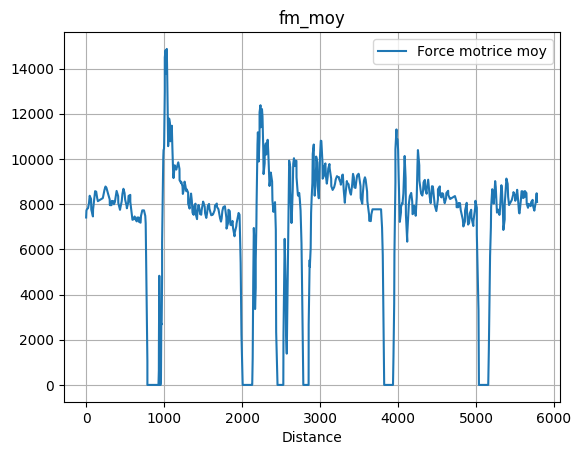

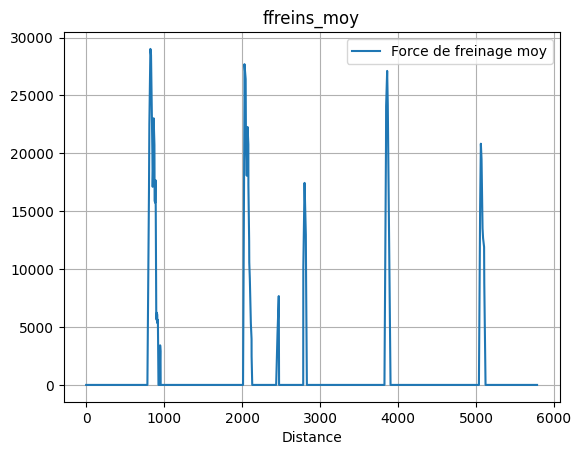

In [ ]:
def cinématique (annee,circuit,session,pilote, Nax: int, Nay: int, Naz:int) -> pd.DataFrame:


    epreuve = fastf1.get_session(annee, circuit, session)
    epreuve.load(telemetry=True, laps=True, weather=True)
    circuit_info:pd.DataFrame = epreuve.get_circuit_info()
    tour:pd.DataFrame = epreuve.laps.pick_drivers(pilote).pick_fastest().dropna()
    pos = tour.get_pos_data().copy()

    df_corners = circuit_info.corners
    df_corners = df_corners.loc[:, ["Number", "Distance"]]

    
    #pos = pd.concat([pos, pos.iloc[[0]]], ignore_index=True)          # Permet que qd je plot y(x) le circuit soit fermé mais à 
    #                                                                    revoir pcq ça me nique mon plot des nouvelles accels
    
    telemetry: pd.DataFrame = tour.get_telemetry().copy()

    print(type(telemetry))

    vx = telemetry["Speed"] / 3.6
    a_scal= np.gradient(vx)
    telemetry['a_scalaire'] = a_scal
    time_float = telemetry["Time"] / np.timedelta64(1, "s")
    dtime = np.gradient(time_float)
    ax = np.gradient(vx) / dtime

    # Clean up outliers
    for i in np.arange(1, len(ax) - 1).astype(int):
        if ax[i] > 25:
            ax[i] = ax[i - 1]

    # Smooth x-acceleration
    a_long_smooth = np.convolve(ax, np.ones((Nax,)) / Nax, mode="same")

    # Get position data
    x = telemetry["X"]
    y = telemetry["Y"]
    z = telemetry["Z"]
    telemetry['altitude'] = telemetry['Z'] - telemetry['Z'].iloc[0]

    # Calculate gradients
    dx = np.gradient(x)
    dy = np.gradient(y)
    dz = np.gradient(z)

    d2x = np.gradient(dx)
    d2y = np.gradient(dy)
    d2z = np.gradient(dz)
    a_vec = np.column_stack((d2x, d2y, d2z))
    

    # Calculate theta (angle in xy-plane)
    theta = np.arctan2(dy, (dx + np.finfo(float).eps))
    theta[0] = theta[1]
    theta_noDiscont = np.unwrap(theta)

    # Calculate distance and curvature
    dist = telemetry["Distance"]
    ds = np.gradient(dist)
    dtheta = np.gradient(theta_noDiscont)

    # Clean up outliers
    for i in np.arange(1, len(dtheta) - 1).astype(int):
        if abs(dtheta[i]) > 0.5:
            dtheta[i] = dtheta[i - 1]

    # Calculate curvature and lateral acceleration
    C = dtheta / (ds + 0.0001)  # To avoid division by 0
    ay = np.square(vx) * C

    # Remove extreme values
    indexProblems = np.abs(ay) > 150
    ay[indexProblems] = 0
    
    # Smooth y-acceleration
    a_lat_smooth = np.convolve(ay, np.ones((Nay,)) / Nay, mode="same")

    # Calculate z-acceleration (similar process)
    z_theta = np.arctan2(dz, (dx + np.finfo(float).eps))
    z_theta[0] = z_theta[1]
    z_theta_noDiscont = np.unwrap(z_theta)

    z_dtheta = np.gradient(z_theta_noDiscont)

    # Clean up outliers
    for i in np.arange(1, len(z_dtheta) - 1).astype(int):
        if abs(z_dtheta[i]) > 0.5:
            z_dtheta[i] = z_dtheta[i - 1]

    # Calculate z-curvature and vertical acceleration
    z_C = z_dtheta / (ds + 0.0001)
    az = np.square(vx) * z_C

    # Remove extreme values
    indexProblems = np.abs(az) > 150
    az[indexProblems] = 0

    # Smooth z-acceleration
    az_smooth = np.convolve(az, np.ones((Naz,)) / Naz, mode="same")

    telemetry['vx'] = vx
    telemetry["Accélération longitudinale"] = a_long_smooth
    telemetry["Accélération latérale"] = a_lat_smooth
    telemetry["Accélération verticale"] = az_smooth




    if annee < 2018 or annee > 2025:
        print ('Erreur: année non accéptée')
        return


    compound = tour['Compound']

    meteo = tour.get_weather_data()
    humidité_relative = meteo["Humidity"]/100   #pour avoir la valeur comprise entre 0 et 1 
    presssion = meteo["Pressure"] * 100     #pour avoir la pression en Pa
    temp_C = meteo["AirTemp"]
    Rs =  287.058   # constante spécifique de l'air sec

    exp_term = np.exp((17.5043 * temp_C) / (241.2 + temp_C))
    rho = (1 / (Rs * (temp_C + 273.15))) * (presssion - 230.617 * humidité_relative * exp_term)
    g = 9.81
    print(rho)

    years = [2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]
    m = pd.DataFrame({
        'm_moy': [785.5, 798.0, 801.0, 807.0, 853.0, 853.0, 853.0, 855.0],
        'delta_m': [52.5, 55.0, 55.0, 55.0, 55.0, 55.0, 55.0, 55.0]
    }, index=years)

    m['m_max'] = m['m_moy'] + m['delta_m']
    m['m_min'] = m['m_moy'] - m['delta_m']


    A = 1.7

    c = pd.DataFrame({
        'cd_moy': [0.896],
        'cl_moy': [-1.523]
    })

    c['cd_max'] = c['cd_moy'] + 0.1 * c['cd_moy']
    c['cd_min'] = c['cd_moy'] - 0.1 * c['cd_moy']

    c['cl_max'] = c['cl_moy'] + 0.1 * c['cl_moy']
    c['cl_min'] = c['cl_moy'] - 0.1 * c['cl_moy']



    m_moy = m.loc[annee, 'm_moy']
    m_min = m.loc[annee, 'm_min']
    m_max = m.loc[annee, 'm_max']

    # pick aero coefficients
    cd_moy = c.loc[0, 'cd_moy']
    cd_min = c.loc[0, 'cd_min']
    cd_max = c.loc[0, 'cd_max']
    cl_moy = c.loc[0, 'cl_moy']
    cl_min = c.loc[0, 'cl_min']
    cl_max = c.loc[0, 'cl_max']


    telemetry['Portance_min'] = 0.5 * rho * (telemetry['Speed']/3.6)**2 * cl_min * A
    telemetry['Portance_moy'] = 0.5 * rho * (telemetry['Speed']/3.6)**2 * cl_moy * A
    telemetry['Portance_max'] = 0.5 * rho * (telemetry['Speed']/3.6)**2 * cl_max * A

    telemetry['Trainée_min'] = 0.5 * rho * (telemetry['Speed']/3.6)**2 * cd_min * A
    telemetry['Trainée_moy'] = 0.5 * rho * (telemetry['Speed']/3.6)**2 * cd_moy * A
    telemetry['Trainée_max'] = 0.5 * rho * (telemetry['Speed']/3.6)**2 * cd_max * A

    telemetry['Force pesanteur_min'] = m_min * g
    telemetry['Force pesanteur_moy'] = m_moy * g
    telemetry['Force pesanteur_max'] = m_max * g


    P_min = abs(telemetry['Portance_min'])
    P_moy = abs(telemetry['Portance_moy'])
    P_max = abs(telemetry['Portance_max'])



    Cfr_moy = 0.015
    Cfr_min = 0.01
    Cfr_max = 0.02

    telemetry['Force de frottement de roulement min'] = (
        2 * (Cfr_min) * ((P_min + telemetry['Force pesanteur_min'])/4) +
        2 * (Cfr_min) * ((P_min + telemetry['Force pesanteur_min'])/4)
    )

    telemetry['Force de frottement de roulement moy'] = (
        2 * (Cfr_moy) * ((P_moy + telemetry['Force pesanteur_moy'])/4) +
        2 * (Cfr_moy) * ((P_moy + telemetry['Force pesanteur_moy'])/4)
    )

    telemetry['Force de frottement de roulement max'] = (
        2 * (Cfr_max) * ((P_max + telemetry['Force pesanteur_max'])/4) +
        2 * (Cfr_max) * ((P_max + telemetry['Force pesanteur_max'])/4)
    )



    brake_condition = (
        ((telemetry['Brake'] == True) | (telemetry['Accélération longitudinale'] < 0)) &
        (telemetry['Throttle'] < 5)
    )

    # --- Cas 1 : Freinage ---
    telemetry.loc[brake_condition, ['Force motrice max', 'Force motrice moy', 'Force motrice min']] = 0

    # Pendant le freinage :
    # ΣF = m*a  =>  F_frein = -(m*a) + Ff + FD
    # On prend la valeur absolue pour avoir une force positive
    telemetry.loc[brake_condition, 'Force de freinage max'] = np.abs(
        (m_max * telemetry.loc[brake_condition, 'Accélération longitudinale']) +
        (telemetry.loc[brake_condition, 'Force de frottement de roulement min'] +
        telemetry.loc[brake_condition, 'Trainée_min'])
    )

    telemetry.loc[brake_condition, 'Force de freinage moy'] = np.abs(
        (m_moy * telemetry.loc[brake_condition, 'Accélération longitudinale']) +
        (telemetry.loc[brake_condition, 'Force de frottement de roulement moy'] +
        telemetry.loc[brake_condition, 'Trainée_moy'])
    )

    telemetry.loc[brake_condition, 'Force de freinage min'] = np.abs(
        (m_min * telemetry.loc[brake_condition, 'Accélération longitudinale']) +
        (telemetry.loc[brake_condition, 'Force de frottement de roulement min'] +
        telemetry.loc[brake_condition, 'Trainée_min'])
    )


    # --- Cas 2 : Pas de freinage ---
    no_brake_condition = ~brake_condition

    # Pendant la motricité :
    # ΣF = m*a  =>  Fm = m*a + Ff + FD
    telemetry.loc[no_brake_condition, 'Force motrice max'] = (
        (m_max * telemetry.loc[no_brake_condition, 'Accélération longitudinale']) +
        (telemetry.loc[no_brake_condition, 'Force de frottement de roulement min'] +
        telemetry.loc[no_brake_condition, 'Trainée_min'])
    )

    telemetry.loc[no_brake_condition, 'Force motrice moy'] = (
        (m_moy * telemetry.loc[no_brake_condition, 'Accélération longitudinale']) +
        (telemetry.loc[no_brake_condition, 'Force de frottement de roulement moy'] +
        telemetry.loc[no_brake_condition, 'Trainée_moy'])
    )

    telemetry.loc[no_brake_condition, 'Force motrice min'] = (
        (m_min * telemetry.loc[no_brake_condition, 'Accélération longitudinale']) +
        (telemetry.loc[no_brake_condition, 'Force de frottement de roulement max'] +
        telemetry.loc[no_brake_condition, 'Trainée_max'])
    )

    # Pendant l'accélération, il n'y a pas de force de freinage
    telemetry.loc[no_brake_condition, ['Force de freinage max', 'Force de freinage moy', 'Force de freinage min']] = 0

    # --- Post-traitement : éliminer les valeurs motrices négatives (logiquement impossibles)
    telemetry['Force motrice max'] = telemetry['Force motrice max'].clip(lower=0)
    telemetry['Force motrice moy'] = telemetry['Force motrice moy'].clip(lower=0)
    telemetry['Force motrice min'] = telemetry['Force motrice min'].clip(lower=0)

        
        



    

    

    fm_moy = telemetry.plot(x="Distance", y="Force motrice moy", title="fm_moy", grid=True)
    ffreins_moy = telemetry.plot(x="Distance", y="Force de freinage moy", title="ffreins_moy", grid=True)

    track = pos.loc[:, ('X', 'Y')].to_numpy()
    track_angle = circuit_info.rotation / 180 * np.pi
    def rotate(xy, *, angle):
        rot_mat = np.array([[np.cos(angle), np.sin(angle)],
                            [-np.sin(angle), np.cos(angle)]])
        return np.matmul(xy, rot_mat)
    
    rotated_track = rotate(track, angle=track_angle)

    


    return telemetry, rotated_track

cinématique(a_gen, c_gen, s_gen,p_gen, 3, 9, 9)


In [4]:
def dynamics (annee, circuit, session, pilote):
    if annee < 2018 or annee > 2025:
        print ('Erreur: année non accéptée')
        return
    
    epreuve = fastf1.get_session(annee, circuit, session)
    epreuve.load(telemetry=True, laps=True, weather=True)
    circuit_info:pd.DataFrame = epreuve.get_circuit_info()
    tour:pd.DataFrame = epreuve.laps.pick_drivers(pilote).pick_fastest().dropna()

    compound = tour['Compound']
    
    df_corners = circuit_info.corners
    df_corners = df_corners.loc[:, ["Number", "Distance"]]
    
    telemetry: pd.DataFrame = tour.get_telemetry().copy()
    meteo = tour.get_weather_data()
    humidité_relative = meteo["Humidity"]/100   #pour avoir la valeur comprise entre 0 et 1 
    presssion = meteo["Pressure"] * 100     #pour avoir la pression en Pa
    temp_C = meteo["AirTemp"]
    Rs =  287.058   # constante spécifique de l'air sec

    exp_term = np.exp((17.5043 * temp_C) / (241.2 + temp_C))
    rho = (1 / (Rs * (temp_C + 273.15))) * (presssion - 230.617 * humidité_relative * exp_term)
    g = 9.81

    years = [2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]
    m = pd.DataFrame({
        'm_moy': [785.5, 798.0, 801.0, 807.0, 853.0, 853.0, 853.0, 855.0],
        'delta_m': [52.5, 55.0, 55.0, 55.0, 55.0, 55.0, 55.0, 55.0]
    }, index=years)

    m['m_max'] = m['m_moy'] + m['delta_m']
    m['m_min'] = m['m_moy'] - m['delta_m']


    A = 1.7

    c = pd.DataFrame({
        'cd_moy': [0.896],
        'cl_moy': [-1.523]
    })

    c['cd_max'] = c['cd_moy'] + 0.1 * c['cd_moy']
    c['cd_min'] = c['cd_moy'] - 0.1 * c['cd_moy']

    c['cl_max'] = c['cl_moy'] + 0.1 * c['cl_moy']
    c['cl_min'] = c['cl_moy'] - 0.1 * c['cl_moy']

    print(c)
    p = 1.4 * 100000

    rayon = pd.DataFrame({
        'Dry':   [335, 335, 335, 335, 362.5, 362.5, 362.5, 362.5],
        'Wet':   [340, 340, 340, 340, 367.5, 367.5, 367.5, 367.5],
    }, index=years)

    slick = ['HYPERSOFT', 'ULTRASOFT', 'SUPERSOFT', 'SOFT', 'MEDIUM', 'HARD', 'SUPERHARD']
    wet = ['INTERMEDIATE', 'WET']

    if compound in slick:
        R = rayon.loc[annee, 'Dry']   
    elif compound in wet:
        R = rayon.loc[annee, 'Wet']   
    else:
        R = None     


    lar = pd.DataFrame({
        'lar_f_moy': [377.5, 377.5, 377.5, 377.5, 360, 360, 360, 360,],
        'lar_r_moy': [462.5, 462.5, 462.5, 462.5, 455, 455, 455, 455,],
        'delta_lar': [7.5, 7.5, 7.5, 7.5, 15, 15, 15, 15],
    }, index = years)


    lar['lar_f_max'] = lar['lar_f_moy'] + lar['delta_lar']
    lar['lar_f_min'] = lar['lar_f_moy'] - lar['delta_lar']

    lar['lar_r_max'] = lar['lar_r_moy'] + lar['delta_lar']
    lar['lar_r_min'] = lar['lar_r_moy'] - lar['delta_lar']


    """
    telemetry ['Portance'] = 1/2 * rho * (telemetry['Speed']/3.6) * CL * A
    telemetry ['Trainée'] = 1/2 * rho * (telemetry['Speed']/3.6) * CD * A
    telemetry ['Force pesanteur'] = m * g
    telemetry ['Force de frottement de roulement'] = e/R * (telemtry['Portance'] + telemetry["Force pesanteur"])
    telemetry['Force motrice'] = (m * telemetry['Accélération longitudinale']) - (telemetry['Force de frottoment de roulement'] + telemtery['Trainée'])
    
    """



    print(meteo)

dynamics(a_gen, c_gen, s_gen, p_gen, )

core           INFO 	Loading data for Italian Grand Prix - Qualifying [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['7', '5', '44', '77', '33', '8', '55', '31', '10', '18', '20', '35', '14', '27', '3', '11', '16', '28', '9', '2']


   cd_moy  cl_moy  cd_max  cd_min  cl_max  cl_min
0   0.896  -1.523  0.9856  0.8064 -1.6753 -1.3707
Time             0 days 00:29:23.646000
AirTemp                            20.1
Humidity                           66.2
Pressure                          993.9
Rainfall                           True
TrackTemp                          28.5
WindDirection                        57
WindSpeed                           0.5
Name: 29, dtype: object


### Plots

In [5]:

    #plt.plot(pos['Distance'], pos['||a_lat_sin||'], linestyle='-', label='||a_lat_sin||', color='blue')
    plt.figure(figsize=(10,6))
    plt.plot(telemetry["Distance"], telemetry["Accélération longitudinale"], color='green')
    
    # 👉 ADDED: vertical lines at corners
    for _, row in df_corners.iterrows():
        plt.axvline(x=row["Distance"], color="black", linestyle="--", alpha=0.6)
        plt.text(row["Distance"], plt.ylim()[1], str(row["Number"]), 
                rotation=90, va="bottom", ha="center", fontsize=7)
        
    plt.title('Accélération longitudinale en fonction de la distance')
    plt.xlabel("Distance (m)")
    plt.ylabel("Accélération longitudinale (m/s²)")
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10,6))
    plt.plot(telemetry["Distance"], telemetry["Accélération latérale"], color='red')
    
    # 👉 ADDED: vertical lines at corners
    for _, row in df_corners.iterrows():
        plt.axvline(x=row["Distance"], color="black", linestyle="--", alpha=0.6)
        plt.text(row["Distance"], plt.ylim()[1], str(row["Number"]), 
                rotation=90, va="bottom", ha="center", fontsize=7)
        
    plt.title('Accélération latérale en fonction de la distance')
    plt.xlabel("Distance (m)")
    plt.ylabel("Accélération latérale (m/s²)")
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10,6))
    plt.plot(telemetry["Distance"], telemetry["Accélération verticale"], color='red')
    
    # 👉 ADDED: vertical lines at corners
    for _, row in df_corners.iterrows():
        plt.axvline(x=row["Distance"], color="black", linestyle="--", alpha=0.6)
        plt.text(row["Distance"], plt.ylim()[1], str(row["Number"]), 
                rotation=90, va="bottom", ha="center", fontsize=7)
        
    plt.title('Accélération verticale en fonction de la distance')
    plt.xlabel("Distance (m)")
    plt.ylabel("Accélération verticale (m/s²)")
    plt.grid(True)
    plt.show()

NameError: name 'telemetry' is not defined

<Figure size 1000x600 with 0 Axes>